# Projekt - Arhitekture neuronskih mreža
# Segmentacija tumora na mozgu

### 2023./2024.
## Marijana Rendulić

Odvajanje različitih regija mozga na slici (MRI) i točno identificiranje i ocrtavanje regija koje sadrže tumor.

# Motivacija i prednosti


- preciznost označavanja struktura
- poboljšavanje dijagnostičkih procesa
- medicinska istraživanja - brza analiza velikih skupova podataka
- razvoj novih tehnologija
- objektivnost
- automatizacija procesa - smanjivanje obima posla i lista čekanja

# Etički problemi

- Privatnost – anonimiziranje podataka
- Pristranost i preciznost modela
- Validacija od strane zdravstvenih djelatnika


# Biblioteke

In [ ]:
# import system libs
import os
import time
import random
from glob import glob

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.metrics import MeanIoU

import zipfile
from PIL import Image

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Funkcije

**create_df**
- uzima direktorij slika kao ulaz
- Za svaku masku (koja pokazuje lokaciju tumora) pronalazi odgovarajuću sliku mozga (bez istaknutog tumora) uklanjanjem _mask iz naziva
- stvara DataFrame s dva stupca: jedan za putanje do slika mozga i jedan za putanje do odgovarajućih slika maski

**split_df**
- dijeli DataFrame u tri manja za trening, validaciju i testiranje.
  - 80% podataka za trening, a zatim ravnomjerno dijeli preostalih 20% za validaciju i testiranje

In [ ]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

**create_gens**
- priprema slike za model
- batch_size=40
- 256x256
- augmentacije - model bolje uči iz različitih kutova i veličina

- Prije slanja slika modelu, normalizira boje kako bi se osiguralo da ih model ispravno obrađuje
- Za maske prilagođava vrijednosti tako da se sve iznad određenog praga smatra dijelom tumora (1), a sve ostalo nije dijelom tumora (0)

In [ ]:
# Function to create image generators and augmentation
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

# **U-Net arhitektura**

### **U-Net**

- vrsta konvolucijske neuronske mreže (CNN)
- prikladna za segmentaciju slike
  - analiza medicinskih slika - segmentacija tumora na mozgu

- **ARHITEKTURA:**
  - **Input**
    - Model prima sliku veličine 256x256 piksela s 3 kanala boja (RGB).
  - **encoding** (downsampling)
    - tri ''bloka'' koja se sastoje od dva konvolucijska sloja s ReLU aktivacijskom funkcijom, nakon čega slijedi MaxPooling kako bi se smanjile prostorne dimenzije mapa značajki

    - Svaki blok dizajniran je za hvatanje značajki ulazne slike u različitim rezolucijama. Konvolucijski slojevi primjenjuju filtre na ulaz kako bi stvorili mape značajki koje ističu specifične značajke poput rubova, tekstura ili uzoraka. Nakon svakog bloka, MaxPooling sloj smanjuje dimenzionalnost ovih mapa značajki, odnosno prepolavlja njihovu širinu i visinu, što povećava vidno polje i pomaže modelu da zabilježi više globalnih značajki uz smanjeni računalni trošak.
    - Prvi blok ima 32 filtera, a broj filtera se udvostručuje sa svakim sljedećim blokom (od 64,128 do 256 filtera) kako idemo dublje u mrežu.
    - prostorne informacije su komprimirane, a povećava se dubina značajki, odnosno mreža hvata kontekst ulazne slike

  - **decoding** (upsampling)
    - Dekoder zrcali enkoder, ali obrnuto
        - postupno povećava rezoluciju mapa značajki kako bi se rekonstruirala mapa segmentacije iz komprimiranog prikaza značajki
        - vraća prostorne informacije izgubljenje tijekom enkodiranja
    - Ovaj proces pomaže modelu da pročisti granice segmentacije iskorištavanjem lokalnih i globalnih kontekstualnih informacija.
    - Broj filtera u dekoderu smanjuje se sa 128 na 64, i konačno 32 filtera, prije nego što dosegne izlazni sloj
  - između je **bottleneck**
    - sastoji se od dva konvolucijska sloja
    - obrađuje kompresiranu verziju ulaznih podataka, odnosno hvata najapstraktnije značajke slike
    - ima 256 filtara, isti broj kao i posljednji korak u enkoderu
  - **izlazni sloj**
    - posljednji konvolucijski sloj smanjuje dimenziju kanala na 1, te tako stvara konačnu mapu segmentacije
      - iste veličine kao i ulazna slika (256x256), a svaka vrijednost piksela predstavlja vjerojatnost pripadnosti ciljanoj klasi, odnosno regiji tumora

  - omogućuje preciznu lokalizaciju i integraciju konteksta kombiniranjem mapa značajki niske razine s onima visoke razine - ključno za segmentaciju

In [ ]:
# Function that have Unet structure
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoding path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # Decoding path
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])

    return model

### **Koeficijenti i funkcije gubitka**

**dice_coef**
- mjera koliko su dva oblika slična
- uspoređuje područje koje model identificira kao tumor (y_pred) sa stvarnim područjem tumora koje su označili stručnjaci (y_true)

- K.flatten() pretvara slike u jednu liniju piksela radi lakše usporedbe
- intersection izračunava koliko se predviđeno područje tumora preklapa sa stvarnim područjem tumora
- Formula zatim brojniku i nazivniku dodaje mali broj kako bi se izbjeglo dijeljenje s nulom kada nema tumora
  - čini izračun stabilnijim
- dice_coef=1 znači savršeno preklapanje (savršeno predviđanje), dok rezultat dice_coef=0 znači manje preklapanje (lošije predviđanje).

**dice_loss**

- suprotan dice_coeff
- želimo minimizirati gubitak, oduzimanjem dice_coeff od 1 dobivamo nešto što postaje manje kako predviđanja modela postaju bolja
Dakle, poboljšanjem dice_coeff (približavanje 1) smanjuje se dice_loss

**iou_coef**
- IOU (Intersection Over Union) - mjeri koliko se dobro predviđeni tumor preklapa sa stvarnim tumorom
- Sličan kao dice_coeff, ali drugačije izračunava omjer:
  - pronalazi presjek (područje preklapanja između predviđenih i stvarnih tumora)
  - dijeli presjek unijom predviđenih i stvarnih područja tumora. Unija se izračunava zbrajanjem predviđenog i stvarnog područja, te se potom oduzme presjek jer smo ga brojali dvaput
- Kao i kod dice_coeff, mali broj (smooth) se dodaje kako bi se izbjeglo dijeljenje s nulom
- IOU daje ocjenu između 0 i 1, gdje 1 znači savršeno podudaranje, a 0 znači da nema preklapanja

In [ ]:
# Function to calculate Dice Coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Function to calculate Dice Loss
def dice_loss(y_true, y_pred, smooth=100):
    return 1-dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

### **Prikaz uzorka slika**

In [ ]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

## **Podaci**

### Brain MRI segmentation
- Ovaj skup podataka sadrži MR slike mozga zajedno s ručno označenim FLAIR segmentacijskim maskama koje označavaju abnormalnosti (tumore).
- Slike su dobivene iz The Cancer Imaging Archive (TCIA).
- Slike odgovaraju 110 pacijenata iz zbirke glioma nižeg stupnja Atlasa genoma raka (TCGA) s dostupnim podacima o sekvenci inverzije oslabljene tekućinom (FLAIR) i genomskim klasterima.
- Genomski klasteri tumora i podaci o pacijentima navedeni su u datoteci data.csv.
- MRI rezovi za 3 modaliteta kombinirani u RGB sliku.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/Arh_Projekt/data/archive (2).zip'

extract_to_path = '/content/extracted_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

data_dir = os.path.join(extract_to_path, 'lgg-mri-segmentation/kaggle_3m')

### Priprema i vizualizacija medicinskih slika (MRI mozga) i njihovih odgovarajućih segmentacijskih maski (ukazuju na prisutnost tumora)

**create_df(data_dir)**
- stvara DataFrame koji sadrži putanje do slika i njihovih odgovarajućih maski

**split_df(df)**
- dijeli DataFrame u tri podskupa: trening, validaciju i test
  - učenje iz jednog skupa podataka (trening), podešavanje parametara s drugim (validacija) i procjenu izvedbe na dosad neviđenom skupu podataka (test)

**tr_aug_dict**
- definira skup transformacija (poput rotacije, pomaka i zumiranja) koje se primjenjuju na slike za trening
- augmentacije: pomaže modelu da se bolje generalizira simulirajući različite perspektive, veličine i orijentacije tumora na slikama mozga
  - način da se skup podataka umjetno proširi raznolikijim primjerima bez prikupljanja više podataka

**create_gens(train_df, aug_dict=tr_aug_dict), create_gens(valid_df, aug_dict={}) i create_gens(test_df, aug_dict={})**
- stvaraju generatore za skupove za obuku, validaciju i testove
  - učitavaju slike i maske, primjenjuju navedene augmentacije (trening) i pripremaju ih za model.
  - validacija i test nemaju augmentacije - naznačeno prosljeđivanjem praznog rječnika {}

**show_images(list(train_df['images_paths']), list(train_df['masks_paths']))**
- vizualizira prvih 25 slika i njihove odgovarajuće maske iz trening skupa

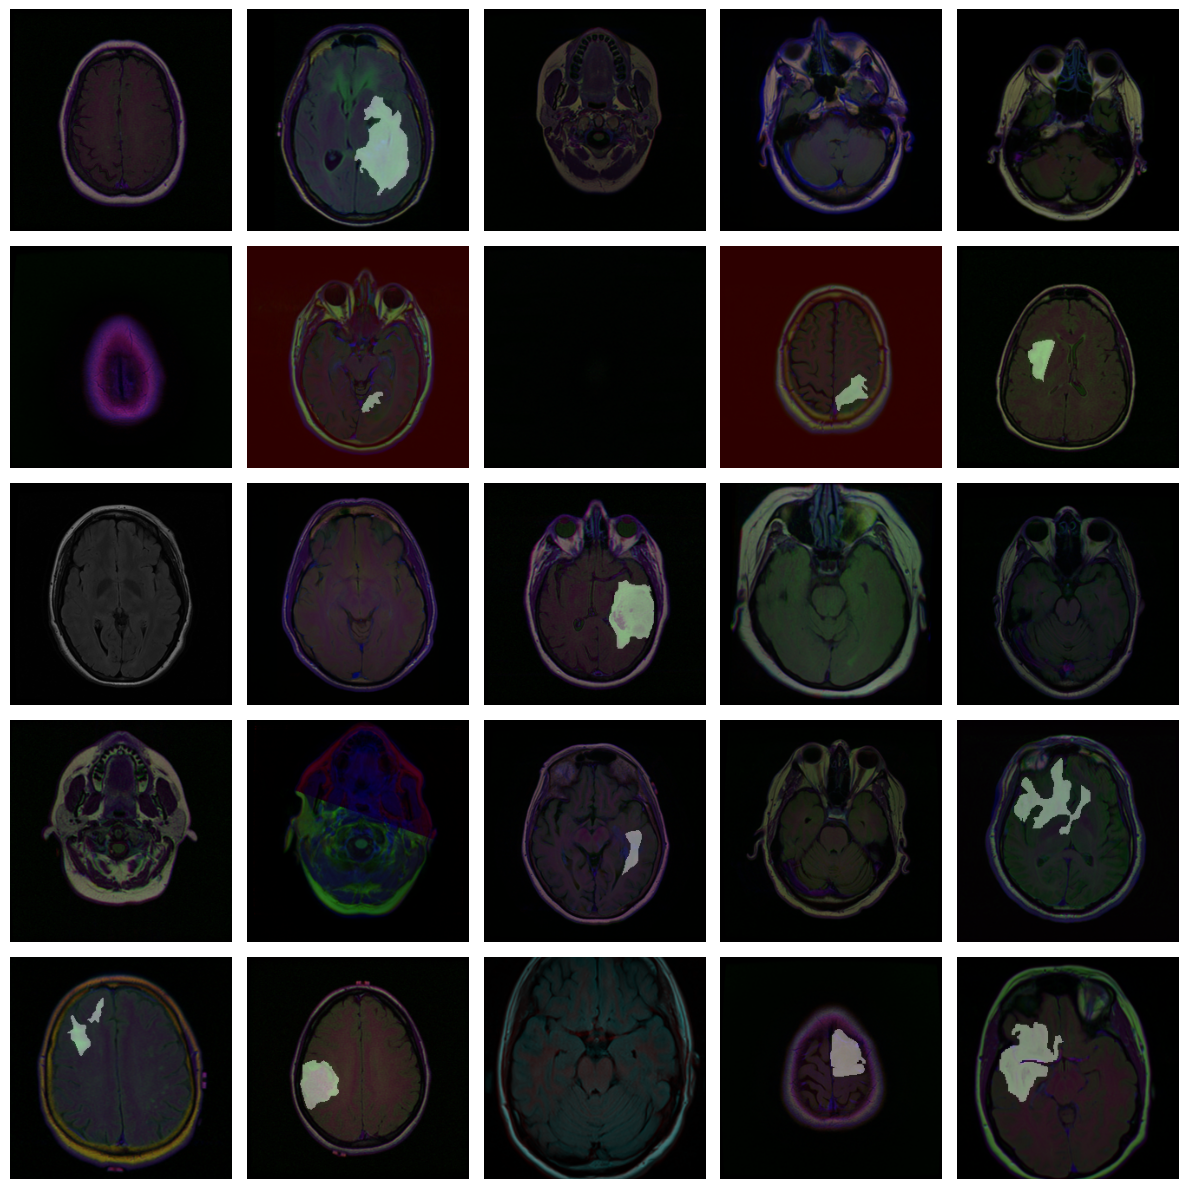

In [ ]:
df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

### **Unet Model**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Arh_Projekt/checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.hdf5"
log_csv_path = '/content/drive/MyDrive/Arh_Projekt/logs/training_log.csv'

Arhitektura modela je pojašnjena iznad.

**optimizator Adam sa stopom učenja 1e-4**
- optimizator se koristi za promjenu atributa neuronske mreže (težine, stope učenja) kako bi se smanjila fja gubitka. Optimizatori pomažu da se rezultati dobiju brže i učinkovitije.
- Adam: vrsta optimizatora koji prilagođava brzinu učenja dok prolazi kroz podatke - veća ili manja ovisno o određenim čimbenicima
  - Ova prilagodljivost pomaže modelu da uči brže i učinkovitije
  - "1e-4" je početna stopa učenja - dobra polazna točka (dovoljno mala da ne preskoči nijedno rješenje, ali ne toliko mala da učenje traje zauvijek)

**funkcija gubitka - dice_loss**
- mjeri koliko dobro model radi, uspoređujući predviđanja modela sa stvarnim maskama
- Cilj uvježbavanja modela je da gubitak bude što manji
- Dice Loss: Izračunava sličnost između predviđene segmentacije i stvarne maske
  - Dice koeficijent
    - 1 znači savršeno preklapanje (najbolje)
    - 0 znači da nema preklapanja (najgore)
  - Dice loss: (1 - Dice coef), pa minimiziranje gubitka znači maksimiziranje preklapanja između predviđenih i stvarnih segmenatacija

#### **metrike - accuracy, dice_coef, iou_coef**
- za procjenu koliko su predviđanja dobra

- **Accuracy:** koji je postotak piksela ispravno klasificiran (na primjer, tumor ili ne-tumor)
  - problem:
    - tumor zauzima mali dio slike, a model predviđa da nema tumora
      - model se i dalje čini dovoljno precizan, ali tumor zapravo postoji

- **Dice coef:**
  - pruža izravnu mjeru preklapanja između predviđene segmentacije i stvarnih maski
  - dobar način za vidjeti koliko dobro model radi konkretno na zadatku segmentacije

- **IOU koeficijent:**
  - Mjeri preklapanje između predviđenog segmenta i stvarnog segmenta kao omjer njihovog preklapanja
  - dobar pokazatelj koliko točno model segmentira sliku

In [ ]:
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', dice_coef, iou_coef])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### **Uvježbavanje modela**

**Postavljanje parametara treninga**
- epohe = 120
  - model će proći kroz cijeli skup podataka za treniranje 120 puta
  - Epoha je jedan potpuni prolaz kroz sve podatke obuke
  - Više epoha može rezultirati boljim učenjem, ali i povećati rizik od prekomjernog prilagođavanja
    - model predobro uči train podatke, ali ima lošu izvedbu na novim, neviđenim podacima

- batch_size = 40
  - model neće obraditi sve podatke odjednom, već će raditi sa 40 slika (i njihovim odgovarajućim maskama) odjednom
  - Manji batchevi zahtijevaju manje memorije i mogu dovesti do boljeg učenja modela, po cijenu brzine obuke

**Callbacks**
- prate proces obuke i izvođenja radnji na temelju performansi modela

- EarlyStopping
  - rano zaustavlja obuku ako se model na validacijskom skupu nije poboljšao 10 epoha (patience=10)
  - Nadzire fju gubitka (monitor='val_loss') i zaustavlja obuku kada se ova vrijednost prestane smanjivati (mode='min')
    - pomaže u sprječavanju overfitanja

- ModelCheckpoint:
  - sprema model (save_best_only=True) samo kada postigne manji gubitak nego u bilo kojoj prethodnoj epohi (monitor='val_loss', mode='min')
    - zadržava se najbolja verzija modela na temelju fje gubitka

- CSVLogger:
  - sprema metrike obuke i validacije modela (gubitak i točnost) u CSV datoteku nakon svake epohe (log_csv_path)
    - za analizu izvedbe modela tijekom vremena

**Obuka modela**
- model.fit:
  - fja koja pokreće proces treninga

- steps_per_epoch
  - definira koliko batcheva podataka model treba obraditi prije nego što se jedna epoha smatra dovršenom
    - Ovdje je postavljeno na polovicu ukupnog broja batcheva koje se mogu stvoriti iz podataka o obuci (len(train_df) / batch_size / 2)
      - za ubrzavanje treninga

- validation_data i validation_steps:
  - Slično obuci, ali za validacijske podatke

- callbacks:
  - popis povratnih poziva definiran ranije

**Cilj:** optimizirati izvedbu modela na validacijskim podacima, ali i spriječiti overfitanje te osigurati spremanje najbolje verzije modela

In [ ]:
epochs = 120

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    CSVLogger(log_csv_path, append=True)
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) / batch_size / 2,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=len(valid_df) / batch_size)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120
99/98 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.9127 - dice_coef: 0.2328 - iou_coef: 0.1474Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to 0.69777, saving model to /content/drive/MyDrive/Arh_Projekt/checkpoints/model_epoch_01_val_loss_0.70.hdf5
98/98 [==============================] - 185s 2s/step - loss: 0.7675 - accuracy: 0.9127 - dice_coef: 0.2328 - iou_coef: 0.1474 - val_loss: 0.6978 - val_accuracy: 0.9675 - val_dice_coef: 0.3025 - val_iou_coef: 0.1824
Epoch 2/120
99/98 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.9863 - dice_coef: 0.4615 - iou_coef: 0.3100
Epoch 2: val_loss improved from 0.69777 to 0.44299, saving model to /content/drive/MyDrive/Arh_Projekt/checkpoints/model_epoch_02_val_loss_0.44.hdf5
98/98 [==============================] - 120s 1s/step - loss: 0.5381 - a

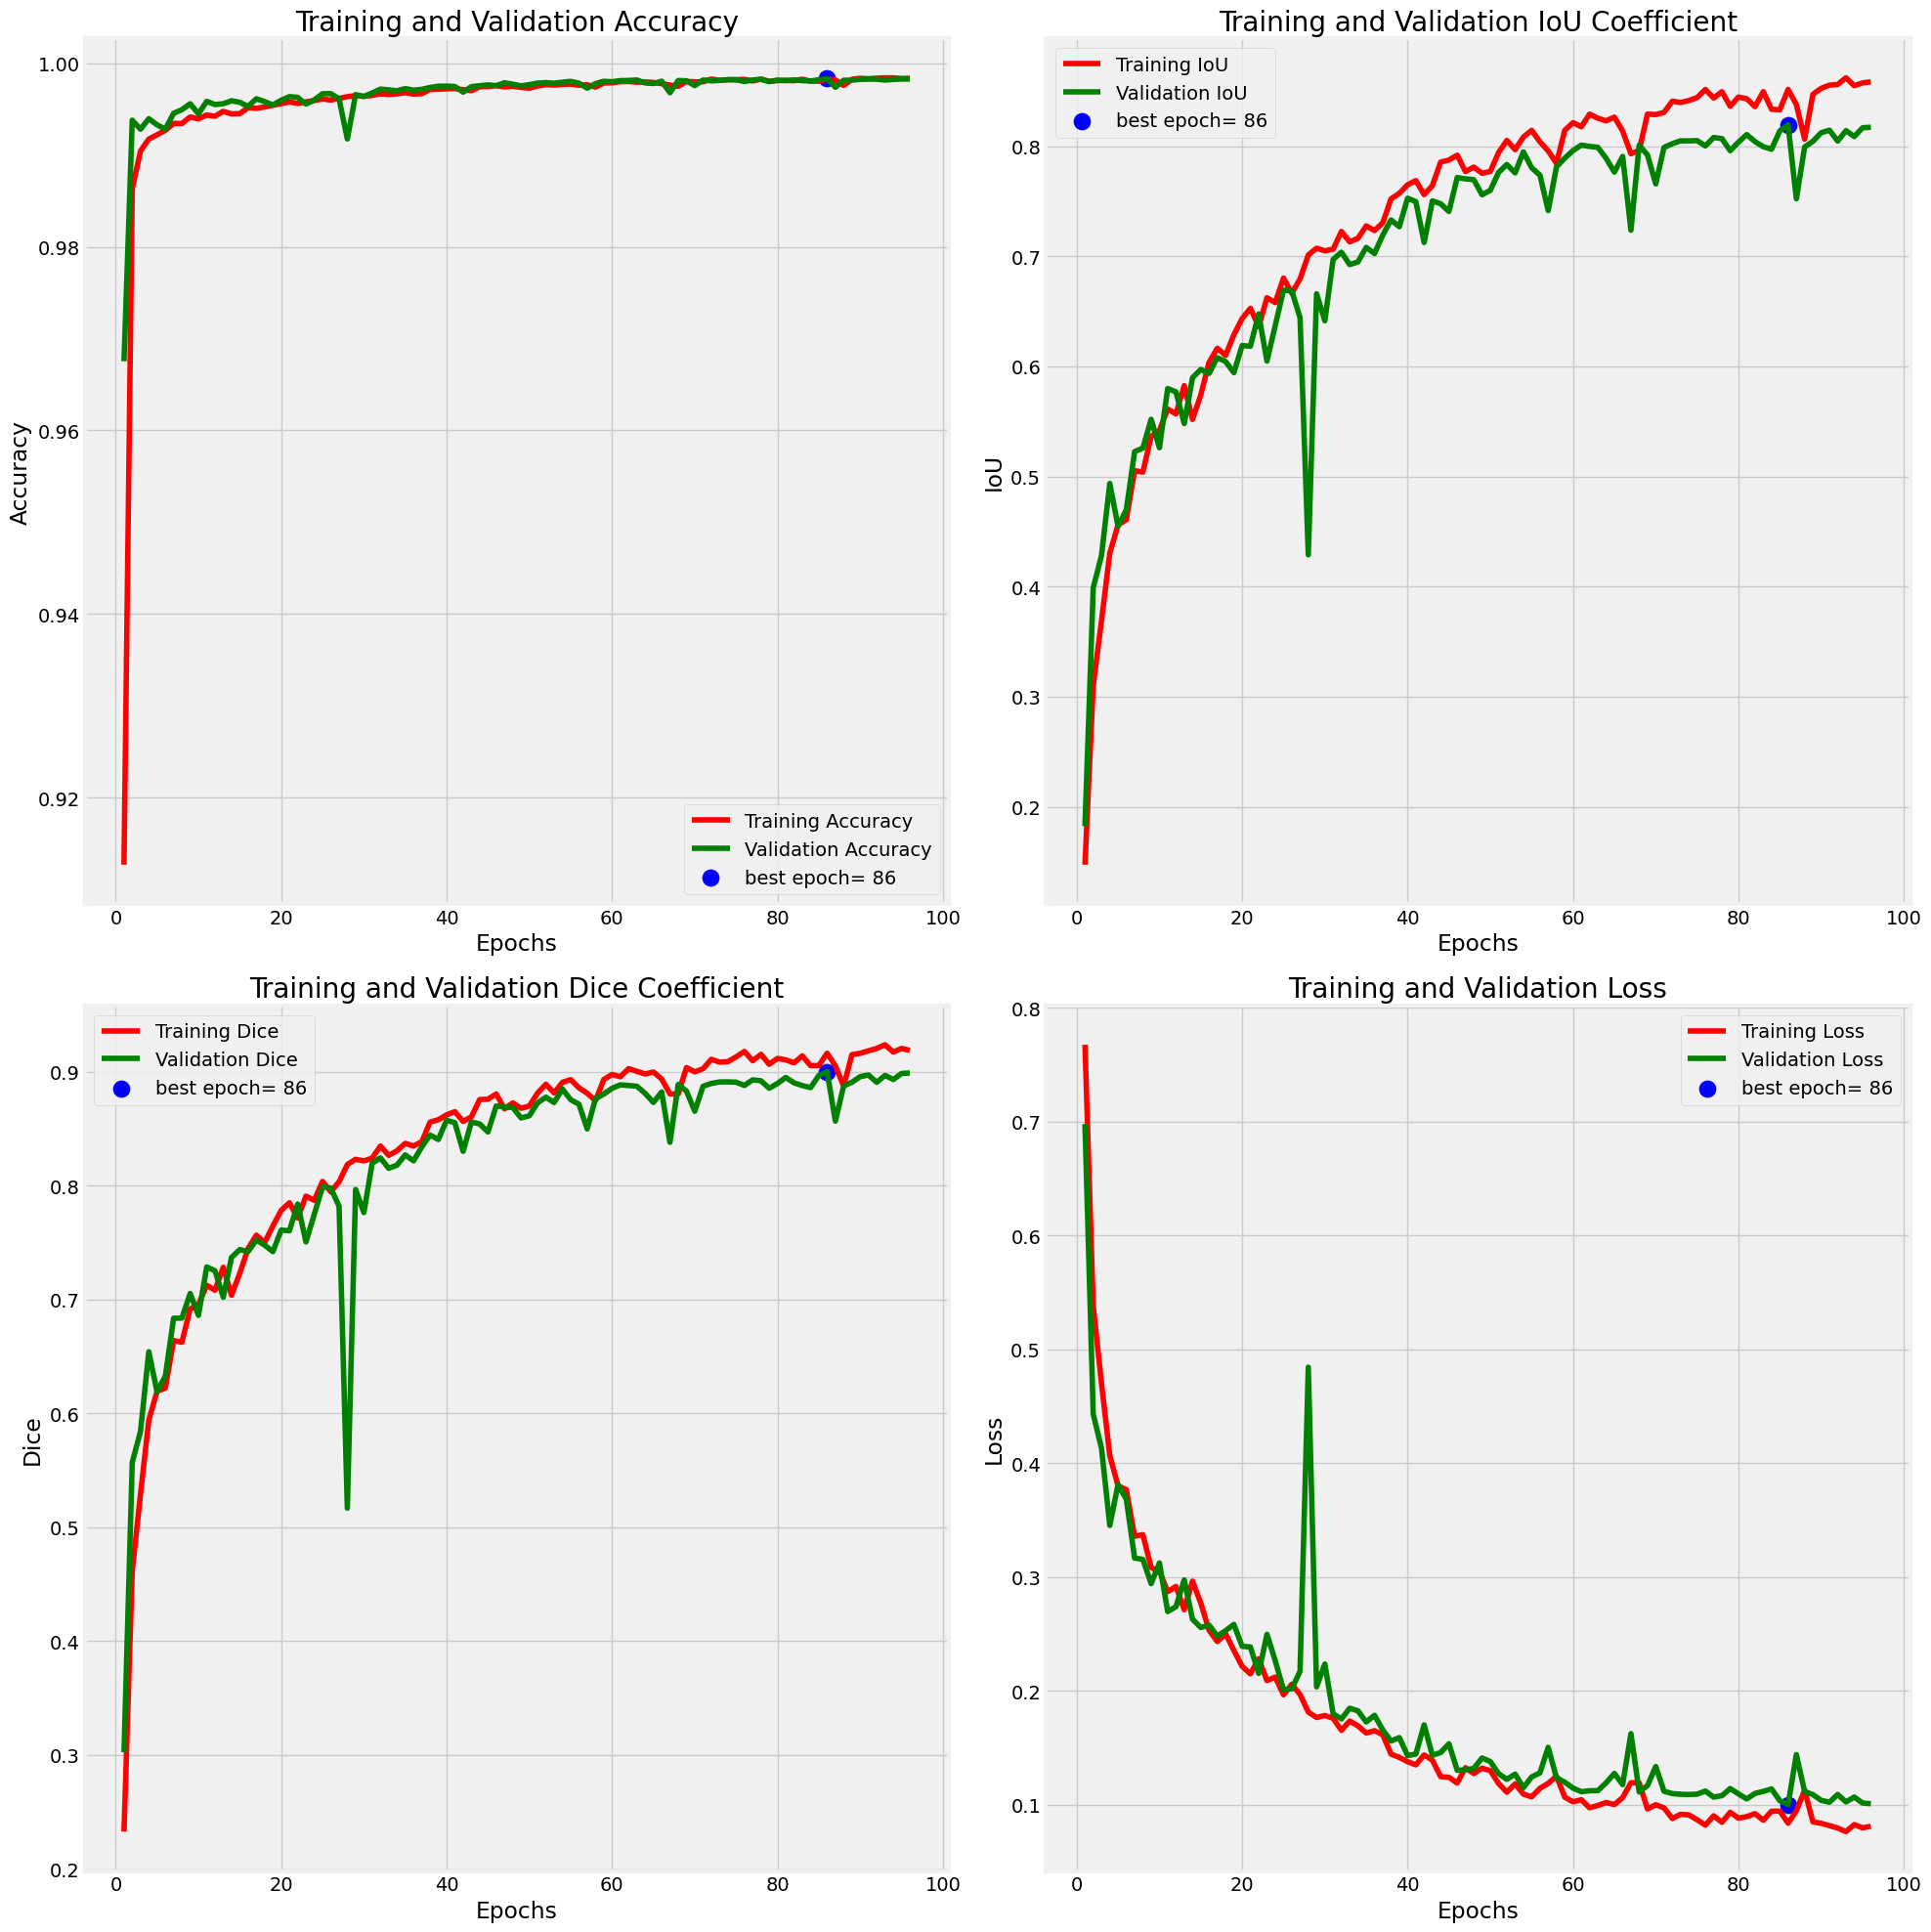

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_training_from_csv(csv_path):
    # Load CSV file into DataFrame
    df = pd.read_csv(csv_path)

    # Extract columns
    tr_acc = df['accuracy']
    tr_iou = df['iou_coef']
    tr_dice = df['dice_coef']
    tr_loss = df['loss']

    val_acc = df['val_accuracy']
    val_iou = df['val_iou_coef']
    val_dice = df['val_dice_coef']
    val_loss = df['val_loss']

    # Find best/worst epochs
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(val_iou)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(val_dice)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    # Generate epochs list
    Epochs = df['epoch'] + 1

    # Labels for the plots
    acc_label = f'best epoch= {index_acc + 1}'
    iou_label = f'best epoch= {index_iou + 1}'
    dice_label = f'best epoch= {index_dice + 1}'
    loss_label = f'best epoch= {index_loss + 1}'

    # Plotting
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label='Training IoU')
    plt.plot(Epochs, val_iou, 'g', label='Validation IoU')
    plt.scatter(index_iou + 1, iou_highest, s=150, c='blue', label=iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label='Training Dice')
    plt.plot(Epochs, val_dice, 'g', label='Validation Dice')
    plt.scatter(index_dice + 1, dice_highest, s=150, c='blue', label=dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
log_csv_path = '/content/drive/MyDrive/Arh_Projekt/logs/training_log.csv'
plot_training_from_csv(log_csv_path)


**IoU koeficijent - trening i validacija**
- značajno se poboljšava s vremenom, model uči bolje segmentirati slike
- Validacijski IoU varira, ali općenito prati trening IoU
  - model dobro generalizira, iako bi moglo doći do overfitanja jer je trening IoU viši od validacijskog IoU

**Dice koeficijent - trening i validacija**
- povećava se s vremenom, pri čemu je za trening nešto viši
  - ponovno ukazuje na to da model uči, ali i da se potencijalno overfita


Nakon određenog broja epoha, i IoU i Dice koeficijenti pokazuju da je model dosegao svoj kapacitet učenja s obzirom na trenutne podatke i arhitekturu

**Fja gubitka - trening i validacija**
- smanjuje se, što je očekivano kako model uči


**Oštri skokovi u validacijskom skupu - IoU, Dice, Fja gubitka**
- Uzrok tome mogu biti razni čimbenici uključujući:
  - Teški ili pogrešno označeni primjeri podataka
  - Privremena stopa učenja koja je previsoka
    - velika ažuriranja težina koje se ne generaliziraju dobro
  - Anomalije u podacima ili u procesu obrade


Općenito, čini se da model radi relativno dobro.
- Eventualno poboljšanje:
  - Prilagodba stope učenja, dodavanje regularizacije, čišćenje podataka ili podešavanje augmentacija
    - može dovesti do boljih i stabilnijih performansi modela

### **Evaluacija modela**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
model_path = '/content/drive/MyDrive/Arh_Projekt/checkpoints/model_epoch_86_val_loss_0.10.hdf5'

# Loading the model with custom objects
custom_objects = {
    "dice_loss": dice_loss,
    "dice_coef": dice_coef,
    "iou_coef": iou_coef
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Calculate the test batch size dynamically
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 [==============================] - 28s 216ms/step - loss: 0.0833 - accuracy: 0.9984 - dice_coef: 0.9167 - iou_coef: 0.8471
Train Loss:  0.0792996734380722
Train Accuracy:  0.9984160661697388
Train IoU:  0.9206588268280029
Train Dice:  0.853851854801178
--------------------
Valid Loss:  0.07939976453781128
Valid Accuracy:  0.9984242916107178
Valid IoU:  0.9205762147903442
Valid Dice:  0.8536205887794495
--------------------
Test Loss:  0.08330904692411423
Test Accuracy:  0.9983956813812256
Test IoU:  0.9167132377624512
Test Dice:  0.8470894694328308


**Rezultati evaluacije:**

- Fja gubitka treninga, validacije i testa prilično je niska (~0,08) - dobro
- Točnost je iznimno visoka (~99,84%) za sva tri skupa podataka
  - kod segmentacije točnost može dovesti u zabludu
    - npr. pozadina dominira slikom, pa je model vrlo točan iako ne radi dobro na stvarnom zadatku segmentacije
- IoU i Dice koeficijent - izravno mjere kvalitetu segmentacije
  - Model ima prilično dobre rezultate na ovim mjernim podacima
    - ~0,85-0,92 za IoU i ~0,84-0,85 za Dice
    - dobro segmentira relevantnih značajki iz pozadine

  - Očekivano: nešto niži rezultati na testnom skupu podataka u usporedbi sa train i validacijskim skupovima
    - pad je neznatan što ukazuje na to da se model dobro generalizira i da se nije overfitao na train podatke

Dakle, rezultati evaluacije pokazuju da model dobro radi u svim podskupovima podataka.

# **Predviđanje**

In [ ]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Izvor

https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

https://www.kaggle.com/code/abdallahwagih/brain-tumor-segmentation-unet-dice-coef-89-6/notebook